In [1]:
setwd('/Users/alexis/University of North Carolina at Chapel Hill - Rager, Julia - CEMALB_DataAnalysisPM/Projects/P1003. Ozone Sterols Healthy Asthma/P1003.3. Analyses/P1003.3.2. Ozone Responder Prediction/Input')
Output = ('/Users/alexis/University of North Carolina at Chapel Hill - Rager, Julia - CEMALB_DataAnalysisPM/Projects/P1003. Ozone Sterols Healthy Asthma/P1003.3. Analyses/P1003.3.2. Ozone Responder Prediction/Output')
cur_date = "040222"

library(readxl)
library(tidyverse)
library(gtsummary)
library(caret)
library(e1071)
library(Hmisc)
library(randomForest)
library(pROC)

#reading in files
ozone_data = data.frame(read_excel("Imputed_Ozone_Data_022822.xlsx")) 
demographics_data = data.frame(read_excel("SubjectInfo_011822.xlsx", sheet = 2))

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.8
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift


Loading required package: survival


Attaching package: ‘survival’


The following object is masked from ‘package:caret’:

    cluster


Loading required package: Formula


Attaching package: ‘Hmisc’


The following object is masked from ‘package:e1071’:

    impute


The following objects are masked from ‘package:dplyr’:

    src, summarize


The following objects are masked from ‘package:base’:

    format.pval, units


randomForest 4.7-1

Type rfNews() to see new features/chan

In [2]:
head(ozone_data)
head(demographics_data)

,Original_Subject_No,Subject_No,Subject_ID,Disease_Status,Sample_Type,Time_Point,Inflammatory_Responder,Lung_Responder,Category,Variable,Value
,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
1,4,1,AS_1,AS,P,Post,NR,NR,Cell_Differential,Sample_Weight,817.00
2,4,1,AS_1,AS,P,Post,NR,NR,Cell_Differential,TCC,395000.00
3,4,1,AS_1,AS,P,Post,NR,NR,Cell_Differential,TCC_Weight,483.48
4,4,1,AS_1,AS,P,Post,NR,NR,Cell_Differential,Neutrophils_Percent,25.00
5,4,1,AS_1,AS,P,Post,NR,NR,Cell_Differential,Neutrophils,98750.00
6,4,1,AS_1,AS,P,Post,NR,NR,Cell_Differential,Neutrophils_Weight,121.00


,Original_Subject_No,Subject_No,Subject_ID,Sex,Race,Ethnicity,Age,BMI,Disease_Status,Visit_Season
,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>
1,4,1,AS_1,M,W,NH,30,23.3,AS,Fa
2,7,2,AS_2,F,W,NH,39,32.7,AS,Sp
3,11,3,AS_3,M,W,NH,23,23.0,AS,Fa
4,13,4,AS_4,M,W,NH,20,21.4,AS,Wi
5,15,5,AS_5,F,B,NH,20,34.5,AS,Su
6,16,6,AS_6,F,W,NH,25,25.2,AS,Su


# Which demographic information and/or soluble mediators in plasma collected at baseline best predict ozone-responder status in asthmatics and non-asthmatics?

In [3]:
plasma_baseline_ozone_data = full_join(demographics_data, ozone_data) %>%
    #only interested in plasma soluble mediators (cytokines/sterols) at baseline
    filter(Sample_Type == "P" & Time_Point == "Pre") %>%
    filter(Category == "Cytokine" | Category == "Sterol") %>%
    select(-c("Sample_Type", "Time_Point", "Category")) %>%
    distinct()
head(plasma_baseline_ozone_data)

Joining, by = c("Original_Subject_No", "Subject_No", "Subject_ID",
"Disease_Status")


,Original_Subject_No,Subject_No,Subject_ID,Sex,Race,Ethnicity,Age,BMI,Disease_Status,Visit_Season,Inflammatory_Responder,Lung_Responder,Variable,Value
,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
1,4,1,AS_1,M,W,NH,30,23.3,AS,Fa,NR,NR,IFNg,8.0557406
2,4,1,AS_1,M,W,NH,30,23.3,AS,Fa,NR,NR,IL10,0.3476302
3,4,1,AS_1,M,W,NH,30,23.3,AS,Fa,NR,NR,IL12p70,0.4572941
4,4,1,AS_1,M,W,NH,30,23.3,AS,Fa,NR,NR,IL13,7.7955008
5,4,1,AS_1,M,W,NH,30,23.3,AS,Fa,NR,NR,IL1b,0.2763808
6,4,1,AS_1,M,W,NH,30,23.3,AS,Fa,NR,NR,IL2,0.5728830


In [4]:
#first pivoting wider to make the tbl_summary function work
wider_data = pivot_wider(plasma_baseline_ozone_data,
                         #not actually taking the mean of multiple values
                         #did this bc cols would be type list rather than double
                         names_from = Variable, values_from = Value, values_fn = mean)

head(wider_data)

Original_Subject_No,Subject_No,Subject_ID,Sex,Race,Ethnicity,Age,BMI,Disease_Status,Visit_Season,⋯,SecoB,bEP_Chol,Lan,Zym,DHL,Des,dHLan,Zyme,Lath,Chol
<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
4,1,AS_1,M,W,NH,30,23.3,AS,Fa,⋯,1.816,25.669,0.171,0.057,0.224,0.641,0.004,3.014,1.969,1110.442
7,2,AS_2,F,W,NH,39,32.7,AS,Sp,⋯,112.521,17.867,0.062,0.046,0.106,0.286,0.015,2.508,1.287,673.328
11,3,AS_3,M,W,NH,23,23.0,AS,Fa,⋯,6.686,8.066,0.052,0.046,0.094,0.279,0.005,1.549,1.200,537.509
13,4,AS_4,M,W,NH,20,21.4,AS,Wi,⋯,48.416,10.132,0.013,0.046,0.085,0.297,0.016,1.833,1.062,482.396
15,5,AS_5,F,B,NH,20,34.5,AS,Su,⋯,13.006,13.090,0.117,0.060,0.116,0.255,0.020,3.628,1.795,586.750
16,6,AS_6,F,W,NH,25,25.2,AS,Su,⋯,36.458,14.331,0.022,0.034,0.077,0.272,0.006,1.914,0.966,639.636


In [5]:
#making responder columns binary denoted by 0 = non-responder and 1 = responder and covariates
wider_data = wider_data %>%
    mutate(Inflammatory_Responder = relevel(factor(ifelse(Inflammatory_Responder == "R", 1, 0)), ref = "0")) %>%
    mutate(Lung_Responder = relevel(factor(ifelse(Lung_Responder == "R", 1, 0)), ref = "0")) %>%
    #for some reason RF didn't this variable so I changed it
    rename(X25OH_VitD = `25OH_VitD`) %>%
    mutate(Sex = relevel(factor(ifelse(Sex == "M", 1, 0)), ref = "0")) %>%
    mutate(Race = relevel(factor(ifelse(Race == "M", 1,
                                        ifelse(Race == "As", 2,
                                        ifelse(Race == "B", 3, 0)))), ref = "0")) %>%
    mutate(Ethnicity = relevel(factor(ifelse(Ethnicity == "H", 1, 0)), ref = "0")) %>%
    mutate(Disease_Status = relevel(factor(ifelse(Disease_Status == "AS", 1, 0)), ref = "0")) %>%
    mutate(Visit_Season = relevel(factor(ifelse(Visit_Season == "Su", 3, 
                                               ifelse(Visit_Season == "Sp", 2,
                                               ifelse(Visit_Season == "Fa", 1, 0)))), ref = "0"))

head(wider_data)

Original_Subject_No,Subject_No,Subject_ID,Sex,Race,Ethnicity,Age,BMI,Disease_Status,Visit_Season,⋯,SecoB,bEP_Chol,Lan,Zym,DHL,Des,dHLan,Zyme,Lath,Chol
<dbl>,<dbl>,<chr>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
4,1,AS_1,1,0,0,30,23.3,1,1,⋯,1.816,25.669,0.171,0.057,0.224,0.641,0.004,3.014,1.969,1110.442
7,2,AS_2,0,0,0,39,32.7,1,2,⋯,112.521,17.867,0.062,0.046,0.106,0.286,0.015,2.508,1.287,673.328
11,3,AS_3,1,0,0,23,23.0,1,1,⋯,6.686,8.066,0.052,0.046,0.094,0.279,0.005,1.549,1.200,537.509
13,4,AS_4,1,0,0,20,21.4,1,0,⋯,48.416,10.132,0.013,0.046,0.085,0.297,0.016,1.833,1.062,482.396
15,5,AS_5,0,3,0,20,34.5,1,3,⋯,13.006,13.090,0.117,0.060,0.116,0.255,0.020,3.628,1.795,586.750
16,6,AS_6,0,0,0,25,25.2,1,3,⋯,36.458,14.331,0.022,0.034,0.077,0.272,0.006,1.914,0.966,639.636


In [6]:
inflamm_resp_df = wider_data[,11:53] %>% select(-Lung_Responder)
inflamm_resp_covariates_df = wider_data[,4:53] %>% select(-Lung_Responder)
lung_resp_df = wider_data[,12:53]
lung_resp_covariates_df = wider_data[,4:53] %>% select(-Inflammatory_Responder)

head(lung_resp_covariates_df)

Sex,Race,Ethnicity,Age,BMI,Disease_Status,Visit_Season,Lung_Responder,IFNg,IL10,⋯,SecoB,bEP_Chol,Lan,Zym,DHL,Des,dHLan,Zyme,Lath,Chol
<fct>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<fct>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,0,30,23.3,1,1,0,8.055741,0.3476302,⋯,1.816,25.669,0.171,0.057,0.224,0.641,0.004,3.014,1.969,1110.442
0,0,0,39,32.7,1,2,0,5.456212,0.1802846,⋯,112.521,17.867,0.062,0.046,0.106,0.286,0.015,2.508,1.287,673.328
1,0,0,23,23.0,1,1,1,2.902175,0.4177936,⋯,6.686,8.066,0.052,0.046,0.094,0.279,0.005,1.549,1.200,537.509
1,0,0,20,21.4,1,0,0,3.860980,0.3901140,⋯,48.416,10.132,0.013,0.046,0.085,0.297,0.016,1.833,1.062,482.396
0,3,0,20,34.5,1,3,0,2.652720,0.2658850,⋯,13.006,13.090,0.117,0.060,0.116,0.255,0.020,3.628,1.795,586.750
0,0,0,25,25.2,1,3,0,22.007931,0.4377489,⋯,36.458,14.331,0.022,0.034,0.077,0.272,0.006,1.914,0.966,639.636


# Random Forest

- an ensemble learning method operating by constructing a multitude of decision trees at training time, which uses multiple methods to obtain a better predictive performance and includes bagging and random forest
- algorithm uses a bootstrop aggregation, to reduce overfitting the training datset but only a subset of the features are used hence decorrelation of predictors

In [7]:
rf_classification = function(dataset, outcome, pred_outcome){
    # setting for reproducibility
    set.seed(12)
    # splitting data into training and testing sets
    dataset_index = createFolds(dataset[[outcome]], k = 5) # 5 fold CV

    metrics = data.frame()
    variable_importance_df = data.frame()
    roc_objects = c()
    threshold_data = data.frame()
    
    for (i in 1:length(dataset_index)){
        data_train = dataset[-dataset_index[[i]],]
        data_test = dataset[dataset_index[[i]],]

        ntree_values = c(50, 250, 500) # number of trees (not sure if we wanted something different)
        p = dim(dataset)[2] - 1 # number of variables in dataset
        mtry_values = c(p/2, sqrt(p), p)

        # will use ntree and mtry values to determine which combination yields the smallest MSE
        reg_rf_pred_tune = list()
        rf_OOB_errors = list()
        rf_error_df = data.frame()
        for (j in 1:length(ntree_values)){
            for (k in 1:length(mtry_values)){
                reg_rf_pred_tune[[k]] = randomForest(as.formula(paste0(outcome, "~.")), data = data_train, 
                                                     ntree = ntree_values[j], mtry = mtry_values[k])
                rf_OOB_errors[[k]] = data.frame("Tree Number" = ntree_values[j], "Variable Number" = mtry_values[k], 
                                       "OOB_errors" = reg_rf_pred_tune[[k]]$err.rate[ntree_values[j],1])
                rf_error_df = rbind(rf_error_df, rf_OOB_errors[[k]])
            }
        }

        # finding the lowest OOB error using best number of predictors at split and refitting OG tree
        best_oob_errors <- which(rf_error_df$OOB_errors == min(rf_error_df$OOB_errors))

        reg_rf <- randomForest(as.formula(paste0(outcome, "~.")), data = data_train,
        # need to go back and figure out how the number of trees/ variables make a difference even though
        # the errors are the same!!!!
                               ntree = rf_error_df$Tree.Number[min(best_oob_errors)], 
                               mtry = rf_error_df$Variable.Number[min(best_oob_errors)])

        # predicting on test set
        data_test[[pred_outcome]] = predict(reg_rf, newdata = data_test, type = "response")
        
        matrix = confusionMatrix(data = data_test[[pred_outcome]], reference = data_test[[outcome]], 
                                     positive = "1")

        # calculating AUC
        auc = auc(response = data_test[[outcome]], predictor = factor(data_test[[pred_outcome]], ordered = TRUE))

        
        # calculating values to plot ROC curve later
        roc_obj = roc(response = data_test[[outcome]], predictor = factor(data_test[[pred_outcome]], ordered = TRUE))

        #  Return max Youden's index, with specificity and sensitivity
        best_thres_data = data.frame(coords(roc_obj, x = "best", best.method = c("youden", "closest.topleft")))
        threshold_data = rbind(threshold_data, best_thres_data)
        
        # extracting accuracy, sens, spec, PPV to take mean later
        matrix_values = data.frame(t(c(matrix$byClass[11])), t(c(matrix$byClass[1:3])), auc)
        
        # extracting variable importance
        var_importance_values = data.frame(importance(reg_rf)) %>%
            rownames_to_column(var = "Predictor")
        variable_importance_df = rbind(variable_importance_df, var_importance_values)
   
        # adding values to df
        metrics = rbind(metrics, matrix_values)
        
    }
    
    # taking averages/sd 
    metrics = metrics %>%
        summarise(`Balanced Accuracy` = mean(Balanced.Accuracy), Sensitivity = mean(Sensitivity), 
              Specificity = mean(Specificity), PPV = mean(Pos.Pred.Value), AUC = mean(auc))
    
    variable_importance_df = variable_importance_df %>%
        group_by(Predictor) %>%
        summarise(MeanDecreaseGini = mean(MeanDecreaseGini)) %>%
        # sorting by most important variables
        arrange(-MeanDecreaseGini)
  
    # return training set, matrix, variable importance values, (last) roc object, best threshold data
    return(list(data_train, metrics, variable_importance_df, roc_obj, threshold_data))

}

In [8]:
#calling fn
rf_values_inflamm_resp = rf_classification(inflamm_resp_df, "Inflammatory_Responder", "pred_Inflammatory_Responder")
rf_values_lung_resp = rf_classification(lung_resp_df, "Lung_Responder", "pred_Lung_Responder")
rf_values_inflamm_resp_covariates = rf_classification(inflamm_resp_covariates_df, "Inflammatory_Responder", "pred_Inflammatory_Responder")
rf_values_lung_resp_covariates = rf_classification(lung_resp_covariates_df, "Lung_Responder", "pred_Lung_Responder")

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting leve

In [9]:
#viewing results
rf_confusion_matrix = data.frame(Model = c(rep(c("RF Classification"), times = 4)), 
                                 Response = c(rep(c("Inflammatory"), times = 2), rep(c("Lung"), times = 2)),
                                 Covariates = c(rep(c("No", "Yes"), times = 2)), rbind(rf_values_inflamm_resp[[2]], 
                                rf_values_inflamm_resp_covariates[[2]], rf_values_lung_resp[[2]], rf_values_lung_resp_covariates[[2]]))
rf_confusion_matrix

#viewing most significant features
head(rf_values_inflamm_resp[[3]])
head(rf_values_inflamm_resp_covariates[[3]])
head(rf_values_lung_resp[[3]]) 
head(rf_values_lung_resp_covariates[[3]])

Model,Response,Covariates,Balanced.Accuracy,Sensitivity,Specificity,PPV,AUC
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
RF Classification,Inflammatory,No,0.4666667,0.9333333,0.0000000,0.6566667,0.4666667
RF Classification,Inflammatory,Yes,0.5666667,0.9333333,0.2000000,0.7066667,0.5666667
RF Classification,Lung,No,0.7333333,0.8333333,0.6333333,0.7333333,0.7333333
RF Classification,Lung,Yes,0.7166667,0.7000000,0.7333333,0.7666667,0.7166667


Predictor,MeanDecreaseGini
<chr>,<dbl>
IP10,0.8793780
IL8,0.7826965
IL5,0.6637214
MPO,0.5260840
TNFb,0.4634499
Chol,0.4183570


Predictor,MeanDecreaseGini
<chr>,<dbl>
IP10,0.8386137
IL8,0.6418942
IFNg,0.5208788
IL5,0.4707372
Chol,0.4226671
Lath,0.4144562


Predictor,MeanDecreaseGini
<chr>,<dbl>
Chol,1.4365670
X25OH_VitD,0.8685508
dHLan,0.8585950
IL15,0.7775042
Zym,0.6590335
bEP_Chol,0.4080964


Predictor,MeanDecreaseGini
<chr>,<dbl>
Chol,1.1647238
Zym,0.8252515
IL15,0.7162409
dHLan,0.6382048
X25OH_VitD,0.5657178
bEP_Chol,0.3834127


Rerunning RF model with noise variables to determine, which predictors are significant above the background noise.

In [10]:
train_vars_noise_inflamm_resp = rf_values_inflamm_resp[[1]]
train_vars_noise_inflamm_resp_covariates = rf_values_inflamm_resp_covariates[[1]]
train_vars_noise_lung_resp = rf_values_lung_resp[[1]]
train_vars_noise_lung_resp_covariates = rf_values_lung_resp_covariates[[1]]

noise_df = function(train_vars_noise){
    set.seed(7)
    # Add random noise predictors as an additional method to evaluate model performance
    # Adding a column that contains randomly shuffled values from one of the molecules; sampling with replacement
    train_vars_noise$noise1 = sample(train_vars_noise[[colnames(train_vars_noise[3])]], replace = TRUE) 
    train_vars_noise$noise2 = sample(train_vars_noise[[colnames(train_vars_noise[4])]], replace = TRUE)
    train_vars_noise$noise3 = sample(train_vars_noise[[colnames(train_vars_noise[5])]], replace = TRUE)
    train_vars_noise$noise4 = sample(train_vars_noise[[colnames(train_vars_noise[6])]], replace = TRUE)
    train_vars_noise$noise5 = sample(train_vars_noise[[colnames(train_vars_noise[7])]], replace = TRUE)
    
    return(train_vars_noise)
}

#calling fn
noise_training_rf_dataset_inflamm_resp = noise_df(train_vars_noise_inflamm_resp)
noise_training_rf_dataset_inflamm_resp_covariates = noise_df(train_vars_noise_inflamm_resp_covariates)
noise_training_rf_dataset_lung_resp = noise_df(train_vars_noise_lung_resp)
noise_training_rf_dataset_lung_resp_covariates = noise_df(train_vars_noise_lung_resp_covariates)
head(noise_training_rf_dataset_inflamm_resp)

Inflammatory_Responder,IFNg,IL10,IL12p70,IL13,IL1b,IL2,IL4,IL6,IL8,⋯,Des,dHLan,Zyme,Lath,Chol,noise1,noise2,noise3,noise4,noise5
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,8.055741,0.3476302,0.4572941,7.795501,0.2763808,0.57288299,0.08653851,4.27020432,624.862506,⋯,0.641,0.004,3.014,1.969,1110.442,0.2941546,0.1977115,6.487059,0.14162,0.31083845
1,5.456212,0.1802846,0.1292934,2.917929,0.1416200,0.06168000,0.00492000,0.22680099,28.767470,⋯,0.286,0.015,2.508,1.287,673.328,1.6869686,0.1292934,6.253472,0.14162,0.31083845
0,2.902175,0.4177936,0.2590372,5.633180,0.1416200,0.06168000,0.03890678,0.15432565,4.411786,⋯,0.279,0.005,1.549,1.200,537.509,0.4364615,0.2232882,4.514058,0.14162,0.02630618
1,3.860980,0.3901140,0.2232882,5.927085,0.1416200,0.11271804,0.03740718,0.47849981,2.909993,⋯,0.297,0.016,1.833,1.062,482.396,0.1802846,0.1977115,7.171008,0.14162,0.14022184
1,2.652720,0.2658850,0.4454673,4.514058,0.1416200,0.06168000,0.02353853,0.07186388,3.387921,⋯,0.255,0.020,3.628,1.795,586.750,0.4340319,0.4044400,8.770503,0.14162,0.06765131
1,4.231875,0.3173774,0.1977115,5.155282,0.1416200,0.08923517,0.02616190,0.30425588,4.257499,⋯,0.192,0.011,2.155,1.288,614.594,0.2401397,0.4099637,4.514058,0.14162,0.65849808


In [11]:
#calling fn
noise_rf_values_inflamm_resp = rf_classification(noise_training_rf_dataset_inflamm_resp, "Inflammatory_Responder", "pred_Inflammatory_Responder")
noise_rf_values_lung_resp = rf_classification(noise_training_rf_dataset_lung_resp, "Lung_Responder", "pred_Lung_Responder")
noise_rf_values_inflamm_resp_covariates = rf_classification(noise_training_rf_dataset_inflamm_resp_covariates, "Inflammatory_Responder", "pred_Inflammatory_Responder")
noise_rf_values_lung_resp_covariates = rf_classification(noise_training_rf_dataset_lung_resp_covariates, "Lung_Responder", "pred_Lung_Responder")

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting leve

In [12]:
#viewing results
noise_rf_confusion_matrix = data.frame(Model = c(rep(c("RF w/ Noise"), times = 4)), Response = c(rep(c("Inflammatory"), times = 2), rep(c("Lung"), times = 2)),
                                 Covariates = c(rep(c("No", "Yes"), times = 2)), rbind(noise_rf_values_inflamm_resp[[2]], noise_rf_values_inflamm_resp_covariates[[2]],
                                      noise_rf_values_lung_resp[[2]], noise_rf_values_lung_resp_covariates[[2]]))
noise_rf_confusion_matrix

Model,Response,Covariates,Balanced.Accuracy,Sensitivity,Specificity,PPV,AUC
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
RF w/ Noise,Inflammatory,No,0.4666667,0.9333333,0.0,0.6666667,0.4666667
RF w/ Noise,Inflammatory,Yes,0.5000000,1.0000000,0.0,0.6866667,0.5000000
RF w/ Noise,Lung,No,0.6500000,0.8000000,0.5,0.7000000,0.7500000
RF w/ Noise,Lung,Yes,0.6000000,0.8000000,0.4,0.6333333,0.7000000


Calculating the average noise rank to determine, which predictors ranked higher than the highest noise rank. 

In [13]:
noise_importance_values_inflamm = noise_rf_values_inflamm_resp[[3]] %>%
    column_to_rownames(var = "Predictor")
noise_importance_values_lung = noise_rf_values_lung_resp[[3]] %>%
    column_to_rownames(var = "Predictor")
noise_importance_values_inflamm_covariates = noise_rf_values_inflamm_resp_covariates[[3]] %>%
    column_to_rownames(var = "Predictor")
noise_importance_values_lung_covariates = noise_rf_values_lung_resp_covariates[[3]] %>%
    column_to_rownames(var = "Predictor")
head(noise_importance_values_inflamm)

,MeanDecreaseGini
,<dbl>
noise1,0.8557126
IL16,0.3488399
Eotaxin,0.3291924
MPO,0.3249210
IP10,0.3143937
bEP_Chol,0.2758986


In [14]:
highest_noise_rank = function(noise_importance_values){
    #this gives us values between 0 and 1
    #the closer the number gets to 1 the lower it ranks, so the number closest to 1 is the max rank
    noise1rank = which(rownames(noise_importance_values) == "noise1")/nrow(noise_importance_values)
    noise2rank = which(rownames(noise_importance_values) == "noise2")/nrow(noise_importance_values)
    noise3rank = which(rownames(noise_importance_values) == "noise3")/nrow(noise_importance_values)
    noise4rank = which(rownames(noise_importance_values) == "noise4")/nrow(noise_importance_values)
    noise5rank = which(rownames(noise_importance_values) == "noise5")/nrow(noise_importance_values)

    #figuring out which is the highest mean decrease gini or background noise importance value
    highest_noise_rank = min(noise1rank, noise2rank, noise3rank, noise4rank, noise5rank)
    
    return(highest_noise_rank)
}

#calling fn
highest_noise_rank_inflamm = highest_noise_rank(noise_importance_values_inflamm)
highest_noise_rank_lung = highest_noise_rank(noise_importance_values_lung)
highest_noise_rank_inflamm_covariates = highest_noise_rank(noise_importance_values_inflamm_covariates)
highest_noise_rank_lung_covariates = highest_noise_rank(noise_importance_values_lung_covariates)
highest_noise_rank_inflamm
highest_noise_rank_inflamm_covariates
highest_noise_rank_lung
highest_noise_rank_lung_covariates

[1] 0.02173913

[1] 0.7358491

[1] 0.2826087

[1] 0.4339623

In [15]:
last_significant_rank = function(noise_importance_values, highest_noise_rank){
    for (i in 1:length(noise_importance_values$MeanDecreaseGini)){
    #if the row number (index)/# of variables is less than the highest noise rank the loop will continue
        if (i/length(noise_importance_values$MeanDecreaseGini) > highest_noise_rank){
            last_significant_var = i - 1
            break
        }
    }    
    return(last_significant_var)
}

#calling fn
last_significant_rank_inflamm = last_significant_rank(noise_importance_values_inflamm, highest_noise_rank_inflamm)
last_significant_rank_lung = last_significant_rank(noise_importance_values_lung, highest_noise_rank_lung)
last_significant_rank_inflamm_covariates = last_significant_rank(noise_importance_values_inflamm_covariates, highest_noise_rank_inflamm_covariates)
last_significant_rank_lung_covariates = last_significant_rank(noise_importance_values_lung_covariates, highest_noise_rank_lung_covariates)
last_significant_rank_inflamm
last_significant_rank_lung
last_significant_rank_inflamm_covariates
last_significant_rank_lung_covariates

[1] 1

[1] 13

[1] 39

[1] 23

Datasets without covariates contained fewer predictors that ranked above the background noise (0 and 12 vs. 38 and 22), meaning the covariates made other predictors more significant as a result of their inclusion in the models.  

In [16]:
#now getting those significant predictors
significant_predictors_inflamm = rownames(noise_importance_values_inflamm)[1:last_significant_rank_inflamm]
significant_predictors_lung = rownames(noise_importance_values_lung)[1:last_significant_rank_lung]
significant_predictors_inflamm_covariates = rownames(noise_importance_values_inflamm_covariates)[1:last_significant_rank_inflamm_covariates]
significant_predictors_lung_covariates = rownames(noise_importance_values_lung_covariates)[1:last_significant_rank_lung_covariates]

#now subsetting the original dfs
rf_subset_df_inflamm = cbind(Inflamm_Status = inflamm_resp_df$Inflammatory_Responder, inflamm_resp_df[,colnames(inflamm_resp_df) %in% significant_predictors_inflamm])
rf_subset_df_lung = cbind(Lung_Status = lung_resp_df$Lung_Responder, lung_resp_df[,colnames(lung_resp_df) %in% significant_predictors_lung])
rf_subset_df_inflamm_covariates = cbind(Inflamm_Status = inflamm_resp_covariates_df$Inflammatory_Responder, inflamm_resp_covariates_df[,colnames(inflamm_resp_covariates_df) %in% significant_predictors_inflamm_covariates])
rf_subset_df_lung_covariates = cbind(Lung_Status = lung_resp_covariates_df$Lung_Responder, lung_resp_covariates_df[,colnames(lung_resp_covariates_df) %in% significant_predictors_lung_covariates])
head(rf_subset_df_lung)

,Lung_Status,IL8,IL15,IP10,MPO,X25OH_VitD,bEP_Chol,Lan,Zym,DHL,dHLan,Zyme,Chol
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,624.862506,1.759696,331.0857,83623.50,61.57312,25.669,0.171,0.057,0.224,0.004,3.014,1110.442
2,0,28.767470,1.465713,203.0245,33060.15,20.31488,17.867,0.062,0.046,0.106,0.015,2.508,673.328
3,1,4.411786,1.444008,170.4566,38965.50,50.92712,8.066,0.052,0.046,0.094,0.005,1.549,537.509
4,0,2.909993,1.509106,189.4547,41957.62,30.55712,10.132,0.013,0.046,0.085,0.016,1.833,482.396
5,0,3.387921,1.478114,172.6236,168669.50,29.90213,13.090,0.117,0.060,0.116,0.020,3.628,586.750
6,0,3.779592,2.255760,666.9340,130446.50,33.79675,14.331,0.022,0.034,0.077,0.006,1.914,639.636


In [17]:
#getting dataframe ready to export variable importance ranks from above and whether those features passed the 
# background filter
significant_predictors_df_inflamm = data.frame(Predictor = significant_predictors_inflamm, Passed_Filter = c(rep(c("Yes"), 
                                                                    times = length(significant_predictors_inflamm))))
significant_predictors_df_lung = data.frame(Predictor = significant_predictors_lung, Passed_Filter = c(rep(c("Yes"), 
                                                                    times = length(significant_predictors_lung))))
significant_predictors_df_inflamm_covariates = data.frame(Predictor = significant_predictors_inflamm_covariates, Passed_Filter = c(rep(c("Yes"), 
                                                                    times = length(significant_predictors_inflamm_covariates))))
significant_predictors_df_lung_covariates = data.frame(Predictor = significant_predictors_lung_covariates, Passed_Filter = c(rep(c("Yes"), 
                                                                    times = length(significant_predictors_lung_covariates))))

significant_predictors_df_inflamm = full_join(significant_predictors_df_inflamm, rf_values_inflamm_resp[[3]])
significant_predictors_df_lung = full_join(significant_predictors_df_lung, rf_values_lung_resp[[3]])
significant_predictors_df_inflamm_covariates = full_join(significant_predictors_df_inflamm_covariates, rf_values_inflamm_resp_covariates[[3]])
significant_predictors_df_lung_covariates = full_join(significant_predictors_df_lung_covariates, rf_values_lung_resp_covariates[[3]])

head(significant_predictors_df_lung)

Joining, by = "Predictor"
Joining, by = "Predictor"
Joining, by = "Predictor"
Joining, by = "Predictor"


,Predictor,Passed_Filter,MeanDecreaseGini
,<chr>,<chr>,<dbl>
1,Chol,Yes,1.4365670
2,IL15,Yes,0.7775042
3,X25OH_VitD,Yes,0.8685508
4,MPO,Yes,0.1561269
5,dHLan,Yes,0.8585950
6,bEP_Chol,Yes,0.4080964


In [18]:
#exporting variable importance values for all features (without noise variables)
write.csv(significant_predictors_df_inflamm, paste0(Output,"/", cur_date, "_Significant_predictors_inflamm.csv"), row.names = FALSE)
write.csv(significant_predictors_df_lung, paste0(Output,"/", cur_date, "_Significant_predictors_lung.csv"), row.names = FALSE)
write.csv(significant_predictors_df_inflamm_covariates, paste0(Output,"/", cur_date, "_Significant_predictors_inflamm_covariates.csv"), row.names = FALSE)
write.csv(significant_predictors_df_lung_covariates, paste0(Output,"/", cur_date, "_Significant_predictors_lung_covariates.csv"), row.names = FALSE)

#exporting variable importance values for all features (with noise variables)
write.csv(noise_rf_values_inflamm_resp[[3]], paste0(Output,"/", cur_date, "_noise_Significant_predictors_inflamm.csv"), row.names = FALSE)
write.csv(noise_rf_values_lung_resp[[3]], paste0(Output,"/", cur_date, "_noise_Significant_predictors_lung.csv"), row.names = FALSE)
write.csv(noise_rf_values_inflamm_resp_covariates[[3]], paste0(Output,"/", cur_date, "_noise_Significant_predictors_inflamm_covariates.csv"), row.names = FALSE)
write.csv(noise_rf_values_lung_resp_covariates[[3]], paste0(Output,"/", cur_date, "_noise_Significant_predictors_lung_covariates.csv"), row.names = FALSE)

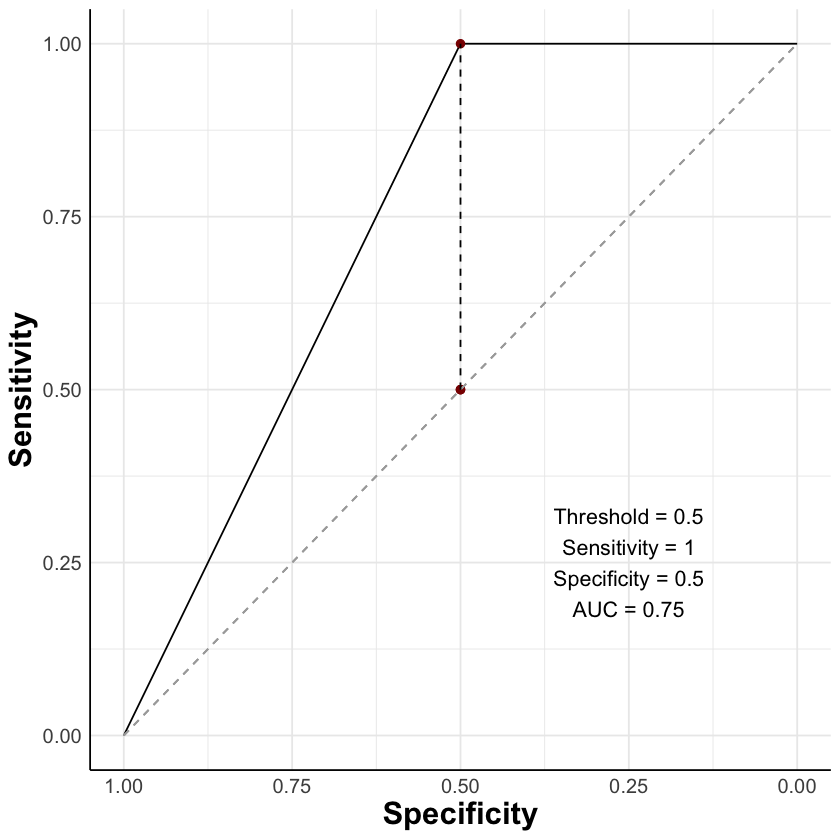

In [19]:
# ROC Curve for lung responder w/o covariates
roc_obj = rf_values_lung_resp[[4]]
# Return max Youden's index, with specificity and sensitivity
best_thres_data = data.frame(coords(roc_obj, x = "best", best.method = c("youden", "closest.topleft")))

# Plot curve, add in line at elbow point
data_add_line = data.frame("sensitvity" = c(1 - best_thres_data$specificity, best_thres_data$sensitivity),
"specificity" = c(best_thres_data$specificity, best_thres_data$specificity))

ggroc(roc_obj) +
  geom_point(data = best_thres_data, aes(x = specificity, y = sensitivity), size = 2, color = "darkred") +
  geom_point(aes(x = best_thres_data$specificity, y = 1 - best_thres_data$specificity), size = 2, color = "darkred") +
  geom_segment(aes(x = 1, xend = 0, y = 0, yend = 1), color = "darkgray", linetype = "dashed") +
  geom_text(data = best_thres_data, aes(x = 0.25, y = 0.25, size = 10,
                                        label = paste0("Threshold = ", round(threshold,2),
  "\nSensitivity = ", round(sensitivity, 2),
  "\nSpecificity = ", round(specificity, 2),
  "\nAUC = ", round(auc(roc_obj), 2)))) +
  geom_line(data = data_add_line, aes(x = specificity, y = sensitvity), linetype = "dashed") +
  
  theme_minimal() + 
  theme(axis.line = element_line(colour = "black"), #making x and y axes black
        axis.text = element_text(size = 12), #changing size of x axis labels
        axis.title = element_text(face = "bold", size = rel(1.7)), #changes axis titles
        legend.position = "none") + 
  xlab('Specificity') + ylab('Sensitivity')  #changing axis labels